#### store_id : 각 파일에서의 상점 고유 번호.
#### date : 거래 일자
#### time : 거래 시간
#### card_id : 카드 번호의 hash 값
#### amount : 매출액, 0보다 작은 음수는 거래 취소(환불), 단위 krw 아님, 할부개월수만큼 amount들어옴
#### installments : 할부개월수. 일시불은 빈 문자열
#### days_of_week : 요일, 월요일이 0, 일요일은 6
#### holyday : 1이면 공휴일, 0이면 공휴일 아님

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
from matplotlib import rc
rc('font', family='AppleGothic')
import seaborn as sns
import numpy as np
from collections import Counter

## 1. Load dataSet

In [82]:
train = pd.read_csv("./train.csv", parse_dates=["date"])
print(train.shape)

(3362796, 8)


In [15]:
train.head()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday,date-year,date-month,date-day,datetime
0,0,2016-12-14,18:05:31,d297bba73f,5,NaN,2,0,2016,12,14,2016-12-14 18:05:31
1,0,2016-12-14,18:05:54,d297bba73f,-5,NaN,2,0,2016,12,14,2016-12-14 18:05:54
2,0,2016-12-19,12:42:31,0880849c05,144,NaN,0,0,2016,12,19,2016-12-19 12:42:31
3,0,2016-12-19,12:48:08,8b4f9e0e95,66,NaN,0,0,2016,12,19,2016-12-19 12:48:08
4,0,2016-12-19,13:31:08,7ad237eed0,24,NaN,0,0,2016,12,19,2016-12-19 13:31:08


In [21]:
train.describe()

,store_id,amount,installments,days_of_week,holyday,date-year,date-month,date-day,hour,minute,second
count,3.362796e+06,3.362796e+06,16860.000000,3.362796e+06,3.362796e+06,3.362796e+06,3.362796e+06,3.362796e+06,3.362796e+06,3.362796e+06,3.362796e+06
mean,8.323770e+02,1.459623e+02,3.459490,3.066320e+00,4.431283e-02,2.017248e+03,6.327452e+00,1.582590e+01,1.535103e+01,2.951374e+01,2.949720e+01
std,5.468544e+02,6.017306e+02,2.382382,1.976153e+00,2.057892e-01,6.764471e-01,3.333864e+00,8.786954e+00,5.191531e+00,1.731957e+01,1.732404e+01
min,0.000000e+00,-2.500000e+05,2.000000,0.000000e+00,0.000000e+00,2.016000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.350000e+02,3.200000e+01,3.000000,1.000000e+00,0.000000e+00,2.017000e+03,4.000000e+00,8.000000e+00,1.200000e+01,1.500000e+01,1.400000e+01
50%,8.220000e+02,7.500000e+01,3.000000,3.000000e+00,0.000000e+00,2.017000e+03,6.000000e+00,1.600000e+01,1.600000e+01,3.000000e+01,2.900000e+01
75%,1.342000e+03,1.500000e+02,3.000000,5.000000e+00,0.000000e+00,2.018000e+03,9.000000e+00,2.300000e+01,1.900000e+01,4.500000e+01,4.500000e+01
max,1.799000e+03,2.500000e+05,36.000000,6.000000e+00,1.000000e+00,2.018000e+03,1.200000e+01,3.100000e+01,2.300000e+01,5.900000e+01,5.900000e+01


## 2. Preprocess

### 2-1. parse date, time
#### date와 time column을 이용해 year, month, day, hour, minute, second column을 생성합니다

In [83]:
train["year"] = train["date"].dt.year
train["month"] = train["date"].dt.month
train["day"] = train["date"].dt.day

In [84]:
train2 = pd.read_csv("./train.csv", parse_dates=["time"])
train2["hour"] = train2["time"].dt.hour
train2["minute"] = train2["time"].dt.minute
train2["second"] = train2["time"].dt.second

In [85]:
train["hour"] = train2["hour"]
train["minute"] = train2["minute"]
train["second"] = train2["second"]
train.head()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday,year,month,day,hour,minute,second
0,0,2016-12-14,18:05:31,d297bba73f,5,NaN,2,0,2016,12,14,18,5,31
1,0,2016-12-14,18:05:54,d297bba73f,-5,NaN,2,0,2016,12,14,18,5,54
2,0,2016-12-19,12:42:31,0880849c05,144,NaN,0,0,2016,12,19,12,42,31
3,0,2016-12-19,12:48:08,8b4f9e0e95,66,NaN,0,0,2016,12,19,12,48,8
4,0,2016-12-19,13:31:08,7ad237eed0,24,NaN,0,0,2016,12,19,13,31,8


In [86]:
train

,store_id,date,time,card_id,amount,installments,days_of_week,holyday,year,month,day,hour,minute,second
0,0,2016-12-14,18:05:31,d297bba73f,5,NaN,2,0,2016,12,14,18,5,31
1,0,2016-12-14,18:05:54,d297bba73f,-5,NaN,2,0,2016,12,14,18,5,54
2,0,2016-12-19,12:42:31,0880849c05,144,NaN,0,0,2016,12,19,12,42,31
3,0,2016-12-19,12:48:08,8b4f9e0e95,66,NaN,0,0,2016,12,19,12,48,8
4,0,2016-12-19,13:31:08,7ad237eed0,24,NaN,0,0,2016,12,19,13,31,8
5,0,2016-12-19,13:36:39,30b1422f77,44,NaN,0,0,2016,12,19,13,36,39
6,0,2016-12-19,14:00:23,6dd8dad5ab,146,NaN,0,0,2016,12,19,14,0,23
7,0,2016-12-19,14:01:36,a4a425c5d2,6,NaN,0,0,2016,12,19,14,1,36
8,0,2016-12-19,14:09:46,f213c011fe,306,NaN,0,0,2016,12,19,14,9,46
9,0,2016-12-19,14:13:02,a185b7b11f,51,NaN,0,0,2016,12,19,14,13,2


In [ ]:
np.percentil(train["amount"])

### 2-2. Remove outliers
#### outlier가 있을 수 있다고 판단되는 column을 선택합니다 -> amount
#### amount column에서 outlier를 찾아 제거합니다

/Users/PJS/anaconda3/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


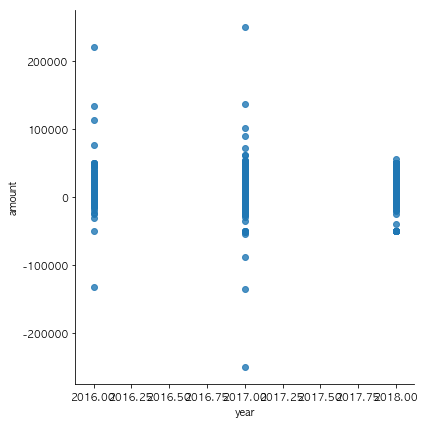

In [148]:
sns.lmplot(data=train, x="year", y="amount", fit_reg=False, size=6, aspect=1)

#### 연도별 amount 범위를 확인합니다

In [151]:
percentage_99 = np.percentile(train["amount"],99)
print(percentage_99)

1335.0


In [152]:
percentage_98 = np.percentile(train["amount"], 98)
print(percentage_98)

800.0


#### amount의 최대값은 250000, 최소값은 -250000입니다
#### amount 값의 약 99%가 차지하는 위치의 값은 1335, 98%가 차지하는 위치의 값은 800입니다
#### 이는 대부분의 data가 1000이하에 위치하고 있음을 의미합니다. 따라서 1000 이상, -1000 이하의 값을 outlier로 간주하겠습니다

In [157]:
train = train.loc[(train["amount"] >= -1000) & (train["amount"] <= 1000)]

#### outlier를 제거하였습니다

### 2-2. Fill in null data
#### null data를 찾아 채워 넣습니다

In [87]:
train.isnull().sum()

store_id              0
date                  0
time                  0
card_id               0
amount                0
installments    3345936
days_of_week          0
holyday               0
year                  0
month                 0
day                   0
hour                  0
minute                0
second                0
dtype: int64

In [88]:
train.loc[train["installments"].isnull(), "installments"] = 1

In [89]:
train.isnull().sum()

store_id        0
date            0
time            0
card_id         0
amount          0
installments    0
days_of_week    0
holyday         0
year            0
month           0
day             0
hour            0
minute          0
second          0
dtype: int64

#### intstallments의 null값은 일시불을 의미하기 때문에, 분할 값 1로 모두 채웠습니다

### 2-3. total
#### total = amount * installments
#### total은 총 금액을 나타나내는 column

In [90]:
train["total"] = train["amount"] * train["installments"]

## 3. Data Analysis

### 3-1. store_id

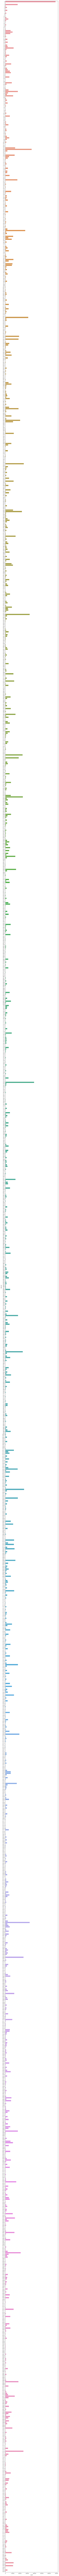

In [41]:
figure, ax = plt.subplots()
figure.set_size_inches(10, 500)
sns.countplot(data=train, y="store_id")

#### store_id column에 따라 coutplot을 확인합니다
#### store_id의 숨겨진 경향성을 확인하고자 하였지만, 따로 확인된 것은 없습니다
#### 가게 마다 거래 기록 count 편차가 심하게 난다는 것을 확인할 수 있습니다
#### store_id의 개수가 1799가 있기 때문에 countplot으로는 확인이 어렵습니다. data frame 형태로 거래 기록 상위 100개를 확인해보도록 하겠습니다

In [198]:
count_list = []
for i in range(1799):
    train_temp = train.loc[train["store_id"] == i]
    values = {"count" : train_temp.shape[0]}
    count_list.append(values)

In [199]:
count_list = pd.DataFrame.from_dict(count_list)

In [200]:
count_list = count_list.sort_values(by="count", ascending=False)

In [204]:
count_list.index.name = "store_id"

In [206]:
count_list.head(10)

,count
store_id,
0,68715
753,39217
105,35999
1342,33325
428,33281
221,31404
161,26108
1038,25694
323,25219


#### 거래 기록이 많은 기준으로 정렬 했을 때, 상위 10개의 가게를 확인했습니다
#### 가장 많은 거래 기록이 있는 store_id는 0이며, 68715(환불기록 포함)개의 거래가 있었습니다
#### 10번째로 거래 기록이 많은 store_id는 1366이며, 24940개의 거래 기록을 갖고 있습니다
#### 거래 기록 기준 상위 10개의 가게는 유동인구가 많은 곳에 위치하였거나, 충성도 높은 고객을 보유하고 있음을 예측할 수 있습니다

In [210]:
train_id_0 = train.loc[train["store_id"] == 0]
train_id_753 = train.loc[train["store_id"] == 753]
train_id_105 = train.loc[train["store_id"] == 105]
train_id_1342 = train.loc[train["store_id"] == 1342]
train_id_428 = train.loc[train["store_id"] == 428]


In [219]:
sum_id_0 = train_id_0["amount"].sum()
sum_id_753 = train_id_753["amount"].sum()
sum_id_105 = train_id_105["amount"].sum()
sum_id_1342 = train_id_1342["amount"].sum()
sum_id_428 = train_id_428["amount"].sum()
print(sum_id_0, train_id_0.shape[0])
print(sum_id_753)
print(sum_id_105)
print(sum_id_1342)
print(sum_id_428)

5156152 68715
9232147
2529649
7295482
1283954


/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


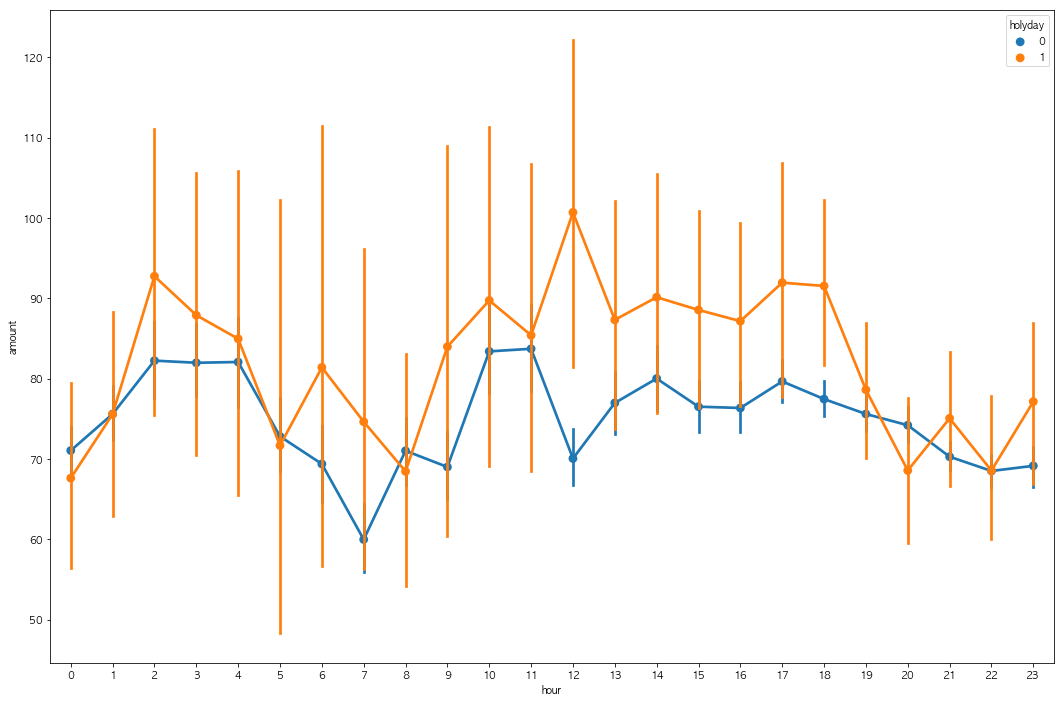

In [209]:
figure, ax = plt.subplots()

# 시각화의 전체 사이즈는 18x12로 설정합니다.
figure.set_size_inches(18, 12)

# seaborn의 pointplot으로 시각당 자전거 대여량을 시각화합니다.
sns.pointplot(data=train_id_0, x="hour", y="amount", hue="holyday")

/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


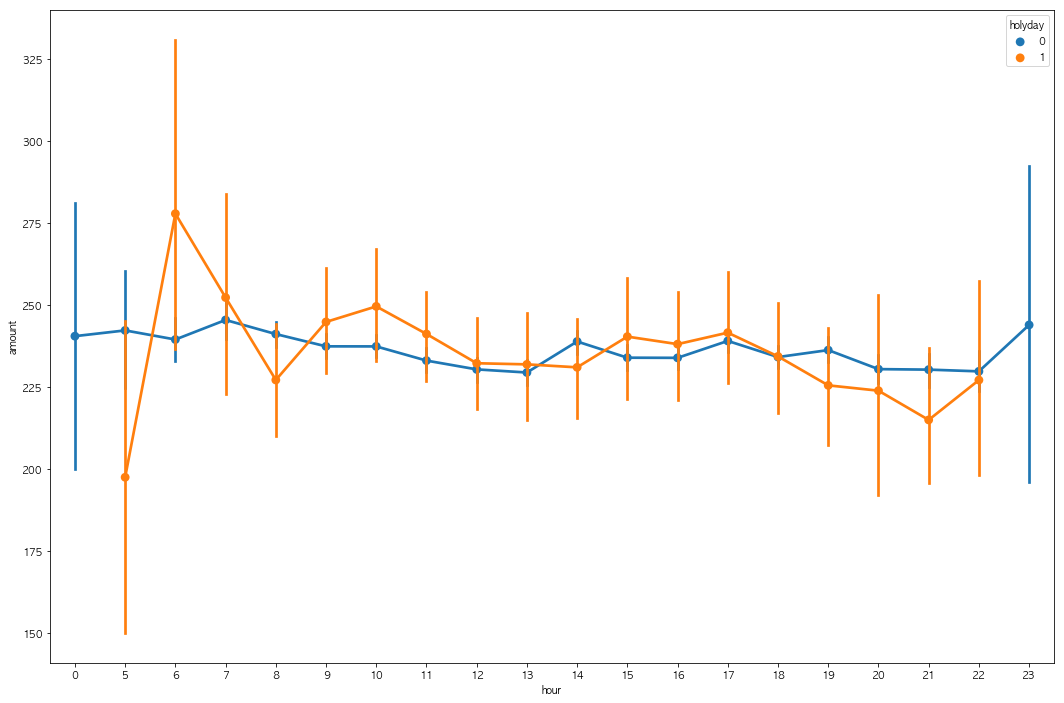

In [211]:
figure, ax = plt.subplots()

# 시각화의 전체 사이즈는 18x12로 설정합니다.
figure.set_size_inches(18, 12)

# seaborn의 pointplot으로 시각당 자전거 대여량을 시각화합니다.
sns.pointplot(data=train_id_753, x="hour", y="amount", hue="holyday")

/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


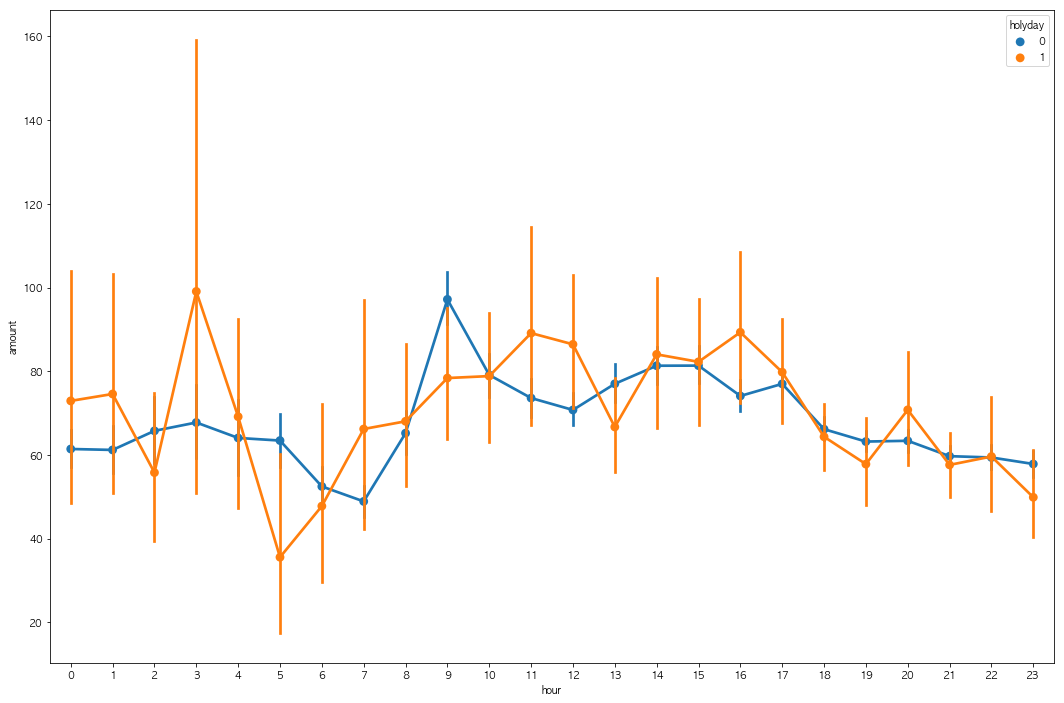

In [212]:
figure, ax = plt.subplots()

# 시각화의 전체 사이즈는 18x12로 설정합니다.
figure.set_size_inches(18, 12)

# seaborn의 pointplot으로 시각당 자전거 대여량을 시각화합니다.
sns.pointplot(data=train_id_105, x="hour", y="amount", hue="holyday")

In [ ]:
pd.pivot_table(train, index="Pclass", values="Survived")

In [28]:
train.tail()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday,date-year,date-month,date-day,datetime,hour,minute,second
3362791,1799,2018-07-19,17:58:31,e254bf70d9,600,0.0,3,0,2018,7,19,2018-07-19 17:58:31,17,58,31
3362792,1799,2018-07-19,18:54:34,8f41c89891,275,0.0,3,0,2018,7,19,2018-07-19 18:54:34,18,54,34
3362793,1799,2018-07-22,14:46:57,aeb64fe1fb,350,0.0,6,0,2018,7,22,2018-07-22 14:46:57,14,46,57
3362794,1799,2018-07-25,18:09:13,57932602d6,300,0.0,2,0,2018,7,25,2018-07-25 18:09:13,18,9,13
3362795,1799,2018-07-30,10:58:53,42d354807a,325,0.0,0,0,2018,7,30,2018-07-30 10:58:53,10,58,53


In [38]:
pd.pivot_table(train, index="store_id", values="count")

KeyError: 'count'

/Users/PJS/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


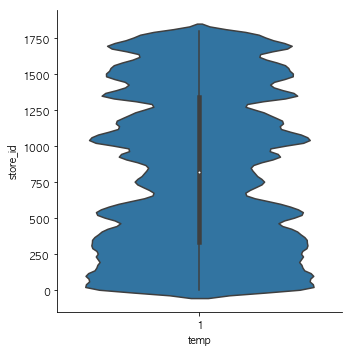

In [44]:
sns.factorplot(data=train, x="temp", y="store_id", kind="violin")

In [103]:
train["temp"] = 1

/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


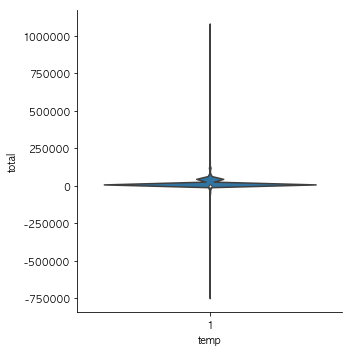

In [105]:
sns.catplot(data=train, x="temp", y="total", kind="violin")

### 3-2. year

/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


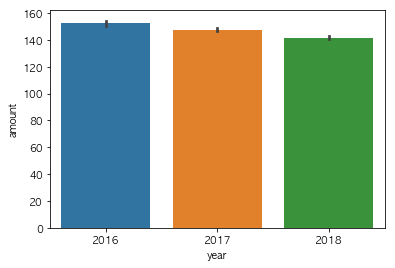

In [91]:
sns.barplot(data=train, x="year", y="amount")

/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


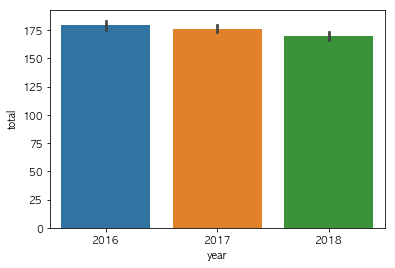

In [95]:
sns.barplot(data=train, x="year", y="total")

### 3-3. month

/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


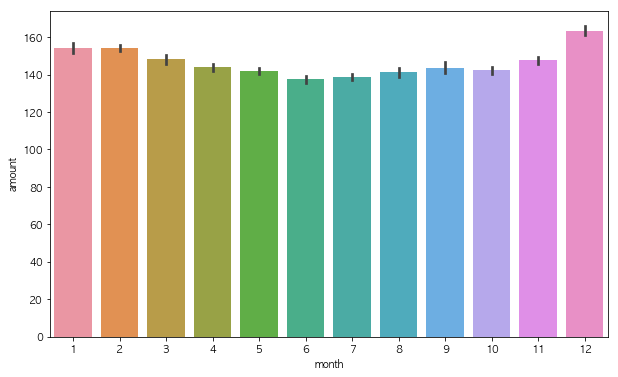

In [92]:
figure, ax = plt.subplots()
figure.set_size_inches(10, 6)
sns.barplot(data=train, x="month", y="amount")

/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


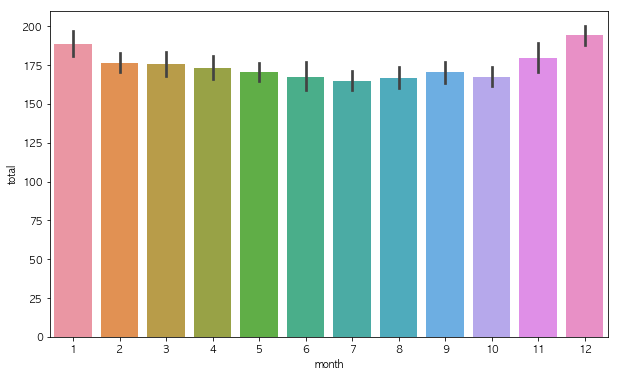

In [96]:
figure, ax = plt.subplots()
figure.set_size_inches(10, 6)
sns.barplot(data=train, x="month", y="total")

/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


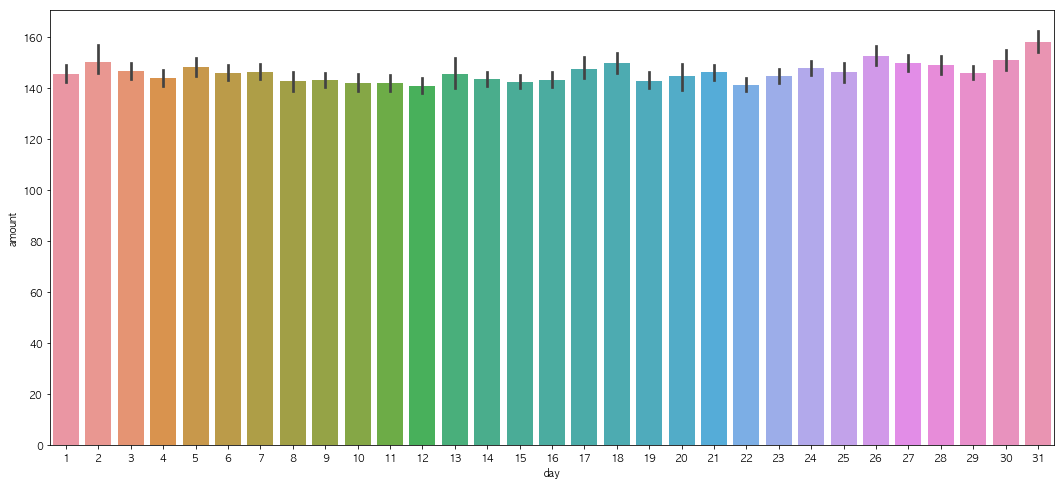

In [94]:
figure, ax = plt.subplots()
figure.set_size_inches(18, 8)
sns.barplot(data=train, x="day", y="amount")

/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


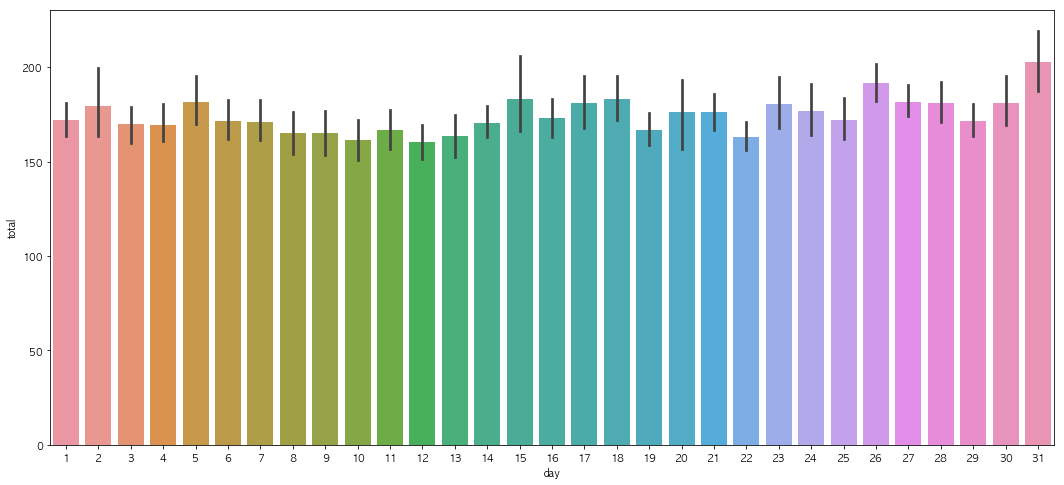

In [97]:
figure, ax = plt.subplots()
figure.set_size_inches(18, 8)
sns.barplot(data=train, x="day", y="total")

/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


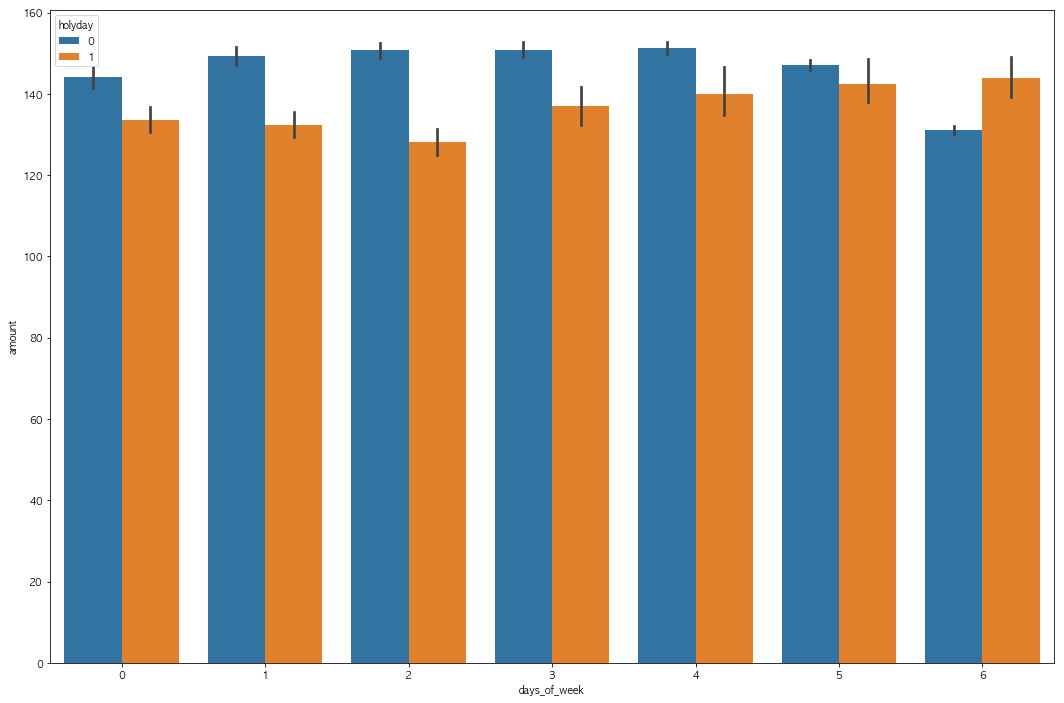

In [77]:
sns.barplot(data=train, x="days_of_week", y="amount", hue="holyday")

/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


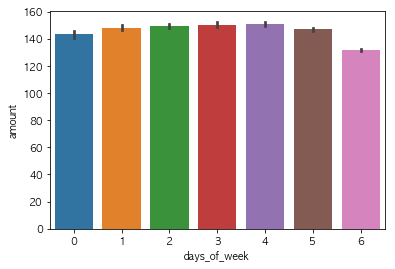

In [78]:
sns.barplot(data=train, x="days_of_week", y="amount")

/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


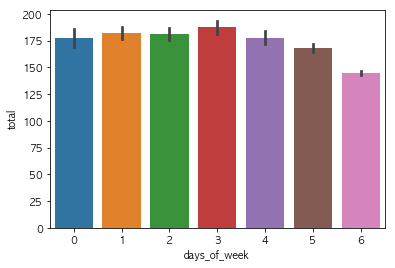

In [98]:
sns.barplot(data=train, x="days_of_week", y="total")

/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


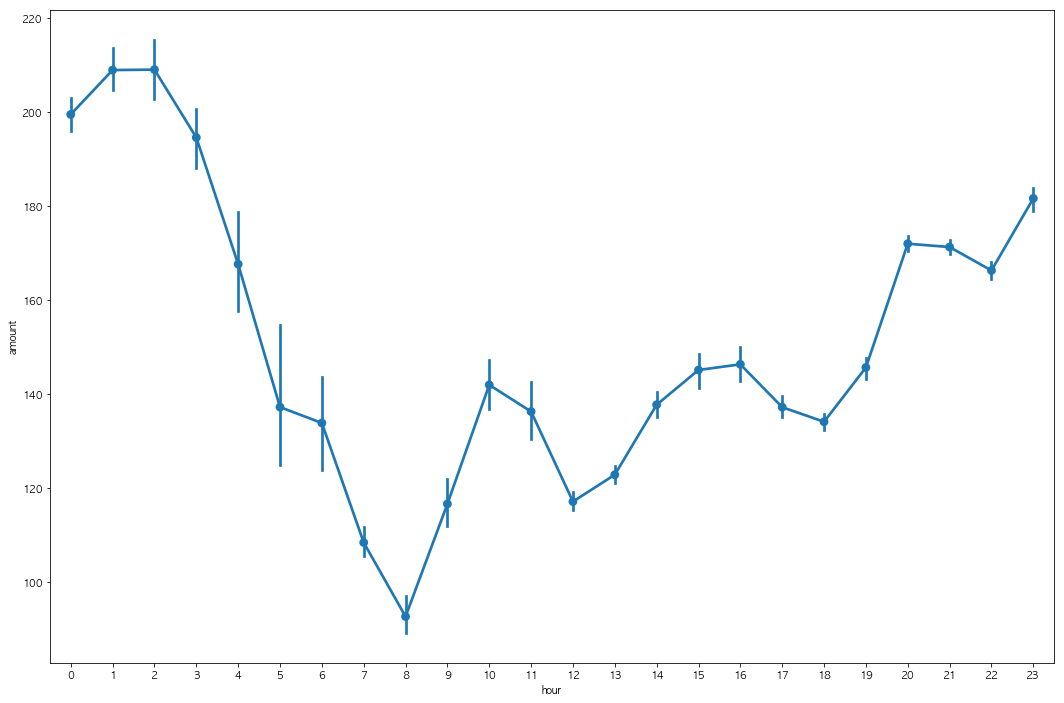

In [46]:
figure, ax = plt.subplots()

# 시각화의 전체 사이즈는 18x12로 설정합니다.
figure.set_size_inches(18, 12)

# seaborn의 pointplot으로 시각당 자전거 대여량을 시각화합니다.
sns.pointplot(data=train, x="hour", y="amount")

/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


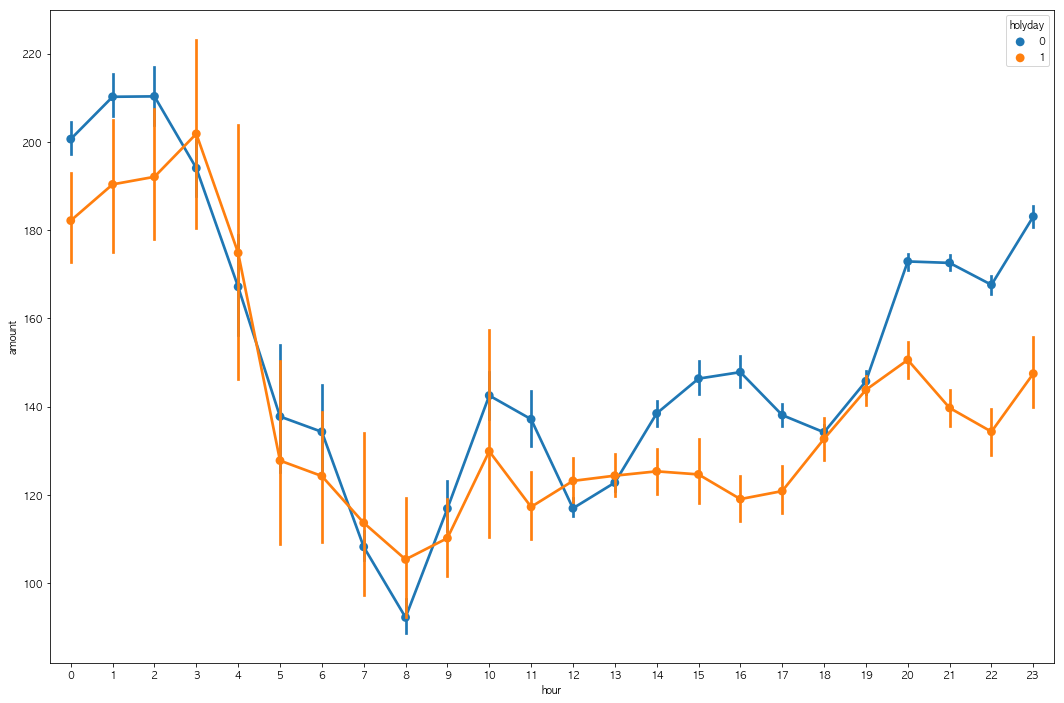

In [54]:
figure, ax = plt.subplots()

# 시각화의 전체 사이즈는 18x12로 설정합니다.
figure.set_size_inches(18, 12)

# seaborn의 pointplot으로 시각당 자전거 대여량을 시각화합니다.
sns.pointplot(data=train, x="hour", y="amount", hue="holyday")

In [ ]:
#### 대부분의 시간대에서 공휴일이 아닌 경우에 amount가 높다. 이는 

/Users/PJS/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


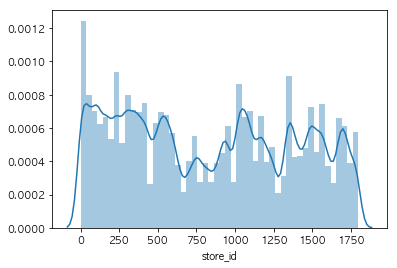

In [53]:
sns.distplot(train["store_id"])